<a href="https://www.kaggle.com/code/mahyararani/predictingshippingcost?scriptVersionId=116556613" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import SelectFromModel

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

In [2]:
train = pd.DataFrame(pd.read_csv('/kaggle/input/hackerearth-machine-learning-exhibit-art/dataset/train.csv'))
test = pd.DataFrame(pd.read_csv('/kaggle/input/hackerearth-machine-learning-exhibit-art/dataset/test.csv'))
print(train.shape)
print(test.shape)

(6500, 20)
(3500, 19)


In [3]:
train.head()

,Customer Id,Artist Name,Artist Reputation,Height,Width,Weight,Material,Price Of Sculpture,Base Shipping Price,International,Express Shipment,Installation Included,Transport,Fragile,Customer Information,Remote Location,Scheduled Date,Delivery Date,Customer Location,Cost
0,fffe3900350033003300,Billy Jenkins,0.26,17.0,6.0,4128.0,Brass,13.91,16.27,Yes,Yes,No,Airways,No,Working Class,No,06/07/15,06/03/15,"New Michelle, OH 50777",-283.29
1,fffe3800330031003900,Jean Bryant,0.28,3.0,3.0,61.0,Brass,6.83,15.00,No,No,No,Roadways,No,Working Class,No,03/06/17,03/05/17,"New Michaelport, WY 12072",-159.96
2,fffe3600370035003100,Laura Miller,0.07,8.0,5.0,237.0,Clay,4.96,21.18,No,No,No,Roadways,Yes,Working Class,Yes,03/09/15,03/08/15,"Bowmanshire, WA 19241",-154.29
3,fffe350031003300,Robert Chaires,0.12,9.0,NaN,NaN,Aluminium,5.81,16.31,No,No,No,NaN,No,Wealthy,Yes,05/24/15,05/20/15,"East Robyn, KY 86375",-161.16
4,fffe3900320038003400,Rosalyn Krol,0.15,17.0,6.0,324.0,Aluminium,3.18,11.94,Yes,Yes,Yes,Airways,No,Working Class,No,12/18/16,12/14/16,"Aprilside, PA 52793",-159.23


In [4]:
def summary(df):
    print(f"Dataset Shape: {df.shape}")
    summary= pd.DataFrame(df.dtypes, columns=['dtypes'])
    summary= summary.reset_index()
    summary['Feature Name'] = summary['index']
    summary = summary[['Feature Name', 'dtypes']]
    summary['missing'] = df.isnull().sum().values
    summary['Uniques'] = df.nunique().values
    return summary

summary(train)

Dataset Shape: (6500, 20)


,Feature Name,dtypes,missing,Uniques
0,Customer Id,object,0,6500
1,Artist Name,object,0,6449
2,Artist Reputation,float64,750,101
3,Height,float64,375,65
4,Width,float64,584,40
5,Weight,float64,587,4410
6,Material,object,764,7
7,Price Of Sculpture,float64,0,3424
8,Base Shipping Price,float64,0,3732
9,International,object,0,2


## The distrubution of features containing Missing Data

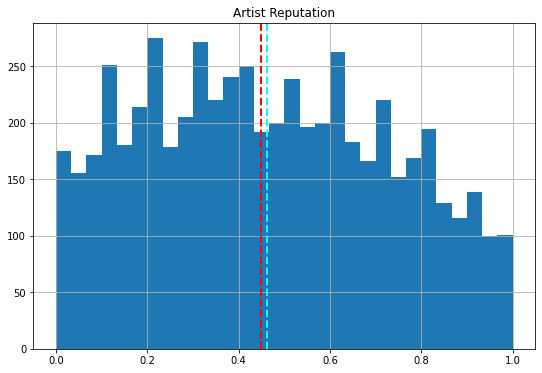

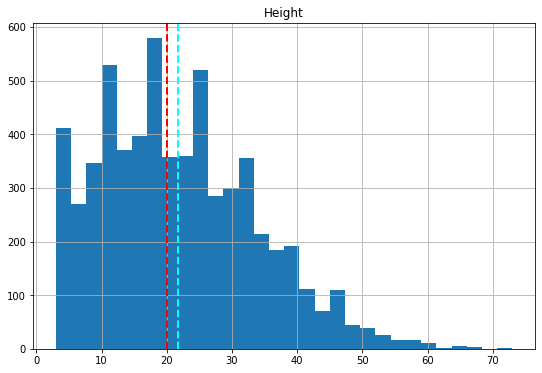

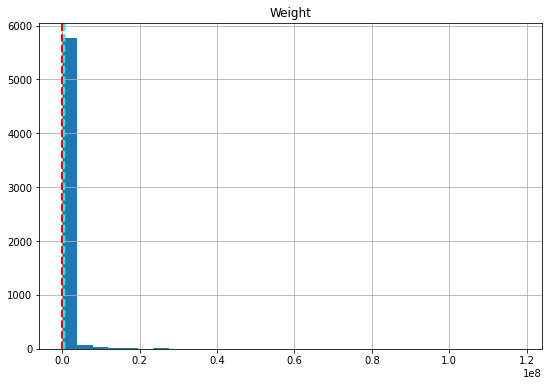

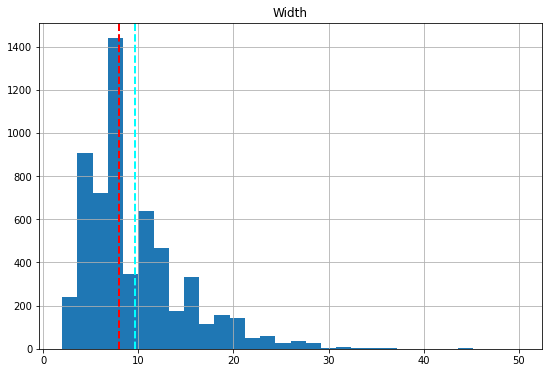

In [5]:
features = ['Artist Reputation', 'Height', 'Weight', 'Width']

for col in features:
    fig = plt.figure(figsize = (9,6))
    ax = fig.gca()
    feature = train[col]
    feature.hist(bins= 30, ax = ax)
    ax.axvline(feature.mean(), color = 'cyan', linestyle  = 'dashed', linewidth = 2)
    ax.axvline(feature.median(), color = 'red', linestyle  = 'dashed', linewidth = 2)
    ax.set_title(col)
plt.show()

## Data Manipulation

In [6]:
def manipulation(df):
    df['State']= df['Customer Location'].str.split(" ").str[-2]
    df['Scheduled Date'] = pd.to_datetime(df['Scheduled Date'])
    df['Delivery Date'] = pd.to_datetime(df['Delivery Date'])
    df['Days Interval'] = (df['Scheduled Date']- df['Delivery Date']).dt.days
    df.drop(['Customer Id','Artist Name', 'Scheduled Date', 'Delivery Date', 'Customer Location'], axis = 1, inplace = True)
    for col in df.columns:
        print(col, ': ', len(df[col].unique()))
    return df

manipulation(train)
train.head()

Artist Reputation :  102
Height :  66
Width :  41
Weight :  4411
Material :  8
Price Of Sculpture :  3424
Base Shipping Price :  3732
International :  2
Express Shipment :  2
Installation Included :  2
Transport :  4
Fragile :  2
Customer Information :  2
Remote Location :  3
Cost :  6356
State :  54
Days Interval :  9


,Artist Reputation,Height,Width,Weight,Material,Price Of Sculpture,Base Shipping Price,International,Express Shipment,Installation Included,Transport,Fragile,Customer Information,Remote Location,Cost,State,Days Interval
0,0.26,17.0,6.0,4128.0,Brass,13.91,16.27,Yes,Yes,No,Airways,No,Working Class,No,-283.29,OH,4
1,0.28,3.0,3.0,61.0,Brass,6.83,15.00,No,No,No,Roadways,No,Working Class,No,-159.96,WY,1
2,0.07,8.0,5.0,237.0,Clay,4.96,21.18,No,No,No,Roadways,Yes,Working Class,Yes,-154.29,WA,1
3,0.12,9.0,NaN,NaN,Aluminium,5.81,16.31,No,No,No,NaN,No,Wealthy,Yes,-161.16,KY,4
4,0.15,17.0,6.0,324.0,Aluminium,3.18,11.94,Yes,Yes,Yes,Airways,No,Working Class,No,-159.23,PA,4


In [7]:
train.dtypes

Artist Reputation        float64
Height                   float64
Width                    float64
Weight                   float64
Material                  object
Price Of Sculpture       float64
Base Shipping Price      float64
International             object
Express Shipment          object
Installation Included     object
Transport                 object
Fragile                   object
Customer Information      object
Remote Location           object
Cost                     float64
State                     object
Days Interval              int64
dtype: object

In [8]:
y = train['Cost'].abs()
X = train.drop(['Cost'], axis =1)

In [9]:
num_df = X.select_dtypes(exclude=object)
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
num_df = pd.DataFrame(imp_median.fit_transform(num_df), columns=num_df.columns)
num_scaled = pd.DataFrame(MinMaxScaler().fit_transform(num_df), columns = num_df.columns)
print(num_scaled.shape)


# Filtering categorical data
cat_df = X.select_dtypes(include=object)
# Filling missing values by most frequent value for categorical columns
imp_mode = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
cat_new = pd.DataFrame(imp_mode.fit_transform(cat_df), columns=cat_df.columns)
cat_df = pd.get_dummies(cat_new)
print(cat_df.shape)

(6500, 7)
(6500, 76)


In [10]:
ETR = ExtraTreesRegressor()

param_grid = {'criterion': ['squared_error', 'absolute_error', 'friedman_mse'],
              'max_depth': range(20, 100, 10),
              'min_samples_leaf': range(1, 21, 1),
              'min_samples_split': range(2, 21, 2),
              'n_estimators': range(20, 500, 20)
             }

ETCR = RandomizedSearchCV(estimator = ETR,
                            param_distributions = param_grid,
                            scoring = 'neg_mean_absolute_error',
                            n_iter = 20,
                            cv= 2,
                            verbose=2,
                            n_jobs = -1)

ETCR.fit(cat_df, y)
print('Best parameters found:\n', ETCR.best_params_)

Fitting 2 folds for each of 20 candidates, totalling 40 fits
[CV] END criterion=friedman_mse, max_depth=40, min_samples_leaf=5, min_samples_split=16, n_estimators=60; total time=   2.3s
[CV] END criterion=friedman_mse, max_depth=40, min_samples_leaf=18, min_samples_split=8, n_estimators=480; total time=   9.3s
[CV] END criterion=squared_error, max_depth=20, min_samples_leaf=3, min_samples_split=18, n_estimators=440; total time=  13.7s
[CV] END criterion=squared_error, max_depth=40, min_samples_leaf=2, min_samples_split=16, n_estimators=220; total time=  10.3s
[CV] END criterion=squared_error, max_depth=50, min_samples_leaf=16, min_samples_split=12, n_estimators=480; total time=  11.0s
[CV] END criterion=squared_error, max_depth=60, min_samples_leaf=5, min_samples_split=12, n_estimators=20; total time=   0.8s
[CV] END criterion=friedman_mse, max_depth=80, min_samples_leaf=20, min_samples_split=6, n_estimators=60; total time=   1.3s
[CV] END criterion=squared_error, max_depth=70, min_sam

In [11]:
model = SelectFromModel(ETCR.best_estimator_, prefit = True)
feature_idx = model.get_support()
feature_name = cat_df.columns[feature_idx]

cat_new = pd.DataFrame(model.transform(cat_df), columns = feature_name)
print(cat_new.shape)
cat_new.head()

(6500, 10)


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


,Material_Brass,Material_Marble,Material_Stone,Express Shipment_No,Express Shipment_Yes,Installation Included_No,Installation Included_Yes,Fragile_No,Fragile_Yes,Remote Location_Yes
0,1,0,0,0,1,1,0,1,0,0
1,1,0,0,1,0,1,0,1,0,0
2,0,0,0,1,0,1,0,0,1,1
3,0,0,0,1,0,1,0,1,0,1
4,0,0,0,0,1,0,1,1,0,0


## Modeling

In [12]:
X = pd.concat([num_scaled, cat_new], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [13]:
lg = LGBMRegressor(objective = 'regression')

lgb_parameters = {
    'boosting_type': ['gbdt', 'dart'],
    'num_leaves': range(2, 21, 2),
    'max_depth': range(5, 201, 5),
    'learning_rate' : [x / 1000.0 for x in range(10, 1000, 10)],
    'min_child_samples': range(100, 500, 20),
    'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
    'n_estimators': range(20, 1500, 10)
}


lgb_grid = RandomizedSearchCV(estimator = lg,
                            param_distributions = lgb_parameters,
                            scoring = 'neg_mean_absolute_error',
                            n_iter = 50,
                            cv= 3,
                            verbose= 1,
                            n_jobs = -1)

lgb_grid.fit(X_train, y_train)
print('Best parameters found:\n', lgb_grid.best_params_)
print('Best MAE Score: ',abs(lgb_grid.best_score_ ))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best parameters found:
 {'num_leaves': 12, 'n_estimators': 100, 'min_child_weight': 1, 'min_child_samples': 100, 'max_depth': 200, 'learning_rate': 0.2, 'boosting_type': 'dart'}
Best MAE Score:  28070.22528215976


In [14]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

rf = RandomForestRegressor()

param_grid = {'bootstrap': [False, True],
              'criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
              'max_depth': range(10, 201, 10),
              'max_features': ['sqrt', 'log2', None],
              'min_samples_leaf': range(1, 11, 1),
              'min_samples_split': range(2, 11, 2),
              'n_estimators': range(20, 1001, 20)
             }

RF_grid = RandomizedSearchCV(estimator = rf,
                            n_iter = 100,
                            param_distributions = param_grid,
                            scoring = 'neg_mean_absolute_error',
                            cv= 2,
                            verbose=1,
                            n_jobs = -1)

RF_grid.fit(X_train, y_train)
print('Best parameters found:\n', RF_grid.best_params_)
print('Best MAE score :\n', abs(RF_grid.best_score_))

Fitting 2 folds for each of 100 candidates, totalling 200 fits
Best parameters found:
 {'n_estimators': 780, 'min_samples_split': 4, 'min_samples_leaf': 8, 'max_features': None, 'max_depth': 60, 'criterion': 'absolute_error', 'bootstrap': True}
Best MAE score :
 16045.061526883634


## Pipeline

In [15]:
train = pd.DataFrame(pd.read_csv('/kaggle/input/hackerearth-machine-learning-exhibit-art/dataset/train.csv'))
train = manipulation(train)
y = train['Cost'].abs()
X = train.drop(['Cost'], axis =1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

num_df = X_train.select_dtypes(include=np.number).columns
# Numerical Preprocessing
num_pre = Pipeline(steps =
                   [("Num Imputer", SimpleImputer(missing_values=np.nan, strategy='median')),
                    ("Scaler", MinMaxScaler())])


cat_df = X_train.select_dtypes(exclude=np.number).columns
# Categorical Preprocessing
cat_pre = Pipeline(steps =
                   [("Cat Imputer", SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                    ("onehot", OneHotEncoder(handle_unknown='ignore')),
                    ("Categorical_Selector", SelectFromModel(ExtraTreesRegressor(**ETCR.best_params_)))])

# Joining Categorical and Numerical Columns
preprocessor = ColumnTransformer(transformers=[
                                ('num', num_pre, num_df),
                                ('cat', cat_pre, cat_df)])

#Modeling Pipeline
pipe = Pipeline(steps = 
                [('preprocessor', preprocessor),
                 ('RandomForest', RandomForestRegressor(**RF_grid.best_params_))])

pipe.fit(X_train, y_train)

Artist Reputation :  102
Height :  66
Width :  41
Weight :  4411
Material :  8
Price Of Sculpture :  3424
Base Shipping Price :  3732
International :  2
Express Shipment :  2
Installation Included :  2
Transport :  4
Fragile :  2
Customer Information :  2
Remote Location :  3
Cost :  6356
State :  54
Days Interval :  9


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('Num '
                                                                   'Imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('Scaler',
                                                                   MinMaxScaler())]),
                                                  Index(['Artist Reputation', 'Height', 'Width', 'Weight', 'Price Of Sculpture',
       'Base Shipping Price', 'Days Interval'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('Cat '
                                                                   'Imputer',
                                                                   SimpleImputer(st

In [16]:
y_pred = pipe.predict(X_test)
print("MAE Score: ", metrics.mean_absolute_error(y_test, y_pred))
print("RMSE: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2 Score: ', metrics.r2_score(y_test, y_pred))

MAE Score:  8124.859614654837
RMSE:  95852.20488578381
R2 Score:  0.6027174293137693
